### Authors : Filippo Prazzoli, Veronica Finazzi, Alessandro Vitriolo 
### Latest Revision Date: 08/01/2025
### License : GPL v3.0

In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
import sklearn
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
# %matplotlib inline
import os
import time
from IPython.core.interactiveshell import InteractiveShell
import scanpy as sc
from collections import Counter
from scipy.stats import spearmanr
from itertools import chain


import celloracle as co
from celloracle import motif_analysis as ma
from celloracle.utility import save_as_pickled_object
co.__version__


InteractiveShell.ast_node_interactivity = "all"
import gc
gc.collect()

sc.settings.verbosity = 3          # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=150, dpi_save = 300, transparent = 'False', color_map = 'viridis')
sns.set_style("whitegrid")#, {"axes.facecolor": "0.93"})
sns.set_palette('Spectral')
sns.set_context('talk')

# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

os.chdir('')
save_folder = "figures"
os.makedirs(save_folder, exist_ok=True)

earthy_pal_ordered = ["#2C5241","#528670","#81b29a","#a0c9e2","#789FBD",
                      "#5f7893","#3d405b","#634A5B","#88535a","#d26559",
                      "#ef8264","#F1A77A","#f2cc8f","#C8A6A3"]
sns.color_palette(earthy_pal_ordered)
earthy_pal = ["#ef8264", "#3d405b","#81b29a","#f2cc8f","#789FBD",
              "#88535a","#C8A6A3","#F1A77A","#528670","#a0c9e2",
              "#BB6157","#5f7893","#634A5B","#2C5241"]
sns.color_palette(earthy_pal)

# Works
# scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.13.0 pandas==1.5.3 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.4 louvain==0.8.2 pynndescent==0.5.12

Matplotlib is building the font cache; this may take a moment.
2024-06-24 10:50:24.674861: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-24 10:51:06.933919: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-24 10:51:33.638026: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.13.0 pandas==1.5.3 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.4 louvain==0.8.2 pynndescent==0.5.12


[(0.9372549019607843, 0.5098039215686274, 0.39215686274509803),
 (0.23921568627450981, 0.25098039215686274, 0.3568627450980392),
 (0.5058823529411764, 0.6980392156862745, 0.6039215686274509),
 (0.9490196078431372, 0.8, 0.5607843137254902),
 (0.47058823529411764, 0.6235294117647059, 0.7411764705882353),
 (0.5333333333333333, 0.3254901960784314, 0.35294117647058826),
 (0.7843137254901961, 0.6509803921568628, 0.6392156862745098),
 (0.9450980392156862, 0.6549019607843137, 0.47843137254901963),
 (0.3215686274509804, 0.5254901960784314, 0.4392156862745098),
 (0.6274509803921569, 0.788235294117647, 0.8862745098039215),
 (0.7333333333333333, 0.3803921568627451, 0.3411764705882353),
 (0.37254901960784315, 0.47058823529411764, 0.5764705882352941),
 (0.38823529411764707, 0.2901960784313726, 0.3568627450980392),
 (0.17254901960784313, 0.3215686274509804, 0.2549019607843137)]

## Configure paths and plots

In [2]:
import os
homeDir = os.getenv("HOME")

In [4]:
import yaml
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
with open(homeDir+"/utils/rcParams.yaml") as f:
    rcParamsDict = yaml.full_load(f)
    for k in rcParamsDict["rcParams"]:
        print("{} {}".format(k,rcParamsDict["rcParams"][k]))
        plt.rcParams[k] = rcParamsDict["rcParams"][k]
    for k1 in set(list(rcParamsDict)).difference(set(["rcParams"])):
        print("{} {}".format(k1,rcParamsDict[k1]))
import matplotlib.pyplot as plt

scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.13.0 pandas==1.5.3 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.4 louvain==0.8.2 pynndescent==0.5.12
figure.dpi 100
savefig.dpi 300
figure.figsize [4, 4]
axes.facecolor None
figure.facecolor None
font.size 10
image.cmap viridis
dotSize 10


In [5]:
outdir = homeDir+"CellOracle"
figdir = "./figures"
resultsdir = "./results"

if not os.path.exists(outdir):
   # Create a new directory because it does not exist
   os.makedirs(outdir)
    
if not os.path.exists(outdir+"/h5ad"):
   # Create a new directory because it does not exist
   os.makedirs(outdir+"/h5ad")

with open(homeDir+"/utils/colorsMap.yaml", 'r') as f:
    colorsMap = yaml.load(f, Loader=yaml.FullLoader)

if not os.path.exists(figdir):
   # Create a new directory because it does not exist
   os.makedirs(figdir)


if not os.path.exists(resultsdir):
   # Create a new directory because it does not exist
   os.makedirs(resultsdir)


In [6]:
expr_csv = pd.read_csv('2024_05_06_revised.CellTypes.expressed.csv')

sarah_genes_new = pd.read_excel('add_genes_to_GRN.xlsx')
sarah_genes_new_list = sarah_genes_new['Genes'].tolist()


with open('SarahGenes.txt', 'r') as f:
    lines_sarah = set(f.readlines())

sarah_genes = pd.DataFrame(lines_sarah)

gene_extend = pd.concat([expr_csv, sarah_genes])
gene_extend_new = pd.concat([gene_extend, sarah_genes_new])

In [7]:
len(gene_extend_new)

14777

In [8]:
adata = sc.read_h5ad('PostPseudoTimeFull.h5ad')

In [9]:
print(f"Cell number is :{adata.shape[0]}")
print(f"Gene number is :{adata.shape[1]}")

# Base GRN
base_GRN = pd.read_parquet("20240124_tfi.celloracle.parquet", engine='pyarrow')
base_GRN.head()

# Check data in anndata
print("Metadata columns :", list(adata.obs.columns))
print("Dimensional reduction: ", list(adata.obsm.keys()))


#OPT : extract hvg

filter_result = sc.pp.filter_genes_dispersion(adata.X, # compute hvgs
                                              flavor='cell_ranger',
                                              n_top_genes=2500,
                                              log=True)

hvgs = list(adata.var_names[filter_result.gene_subset])
# add wanted genes!
hvgs.extend(lines_sarah)
hvgs.extend(sarah_genes_new_list)
hvgs.extend(adata.var[adata.var.highly_variable].index.tolist())
hvgs = pd.Series(hvgs).unique()
len(hvgs)

hvgs = list(set(hvgs).intersection(set(adata.var_names)))
len(hvgs)

adata_raw = adata.raw.to_adata()
#### Subset the genes
adata_raw = adata_raw[:, hvgs].copy()
adata_raw.var_names

gc.collect()

Cell number is :19638
Gene number is :14582


,peak_id,gene_short_name,9430076C15RIK,AC002126.6,AC012531.1,AC226150.2,AFP,AHR,AHRR,AIRE,...,ZNF784,ZNF8,ZNF816,ZNF85,ZSCAN10,ZSCAN16,ZSCAN22,ZSCAN26,ZSCAN31,ZSCAN4
0,chr10_100027007_100029007,AVPI1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,chr10_100027007_100029007,MORN4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,chr10_100027007_100029007,PI4K2A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,chr10_100170634_100172634,HPS1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,chr10_100170634_100172634,HPSE2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Metadata columns : ['sample_id', 'run_id', 'probe_barcode_ids', 'subject', 'line', 'specimen', 'stage', 'condition', 'notes', 'seqRun', 'original_name', 'project', 'who', 'SC_derivation', 'micoplasma', 'mosaic', 'genSite', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'gene_UMI_ratio', 'log1p_gene_UMI_ratio', 'scDblFinder_score', 'scDblFinder_class', 'n_counts', 'n_genes', 'leiden', 'CellTypes', 'CellTypes_v2', 'S_score', 'G2M_score', 'phase', 'main', 'Pseudotime_main', 'Pseudotime']
Dimensional reduction:  ['X_diffmap', 'X_draw_graph_fr', 'X_pca', 'X_pca_harmony', 'X_umap']
extracting highly variable genes
    finished (0:00:01)


3436

3280

Index(['PYROXD2', 'PAK4', 'PFN2', 'ZNF385D', 'ITGB4', 'ATM', 'C1GALT1C1',
       'GUCA1B', 'TMEM51', 'GLYR1',
       ...
       'SUSD2', 'CCNB1', 'CRHBP', 'F2', 'RBMX2', 'PGM5', 'LIPT2', 'CACNA2D2',
       'MT2A', 'PPIC'],
      dtype='object', length=3280)

994

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 3, etc.
var_group_labels: housekeeping, pluripotency, proliferation, etc.


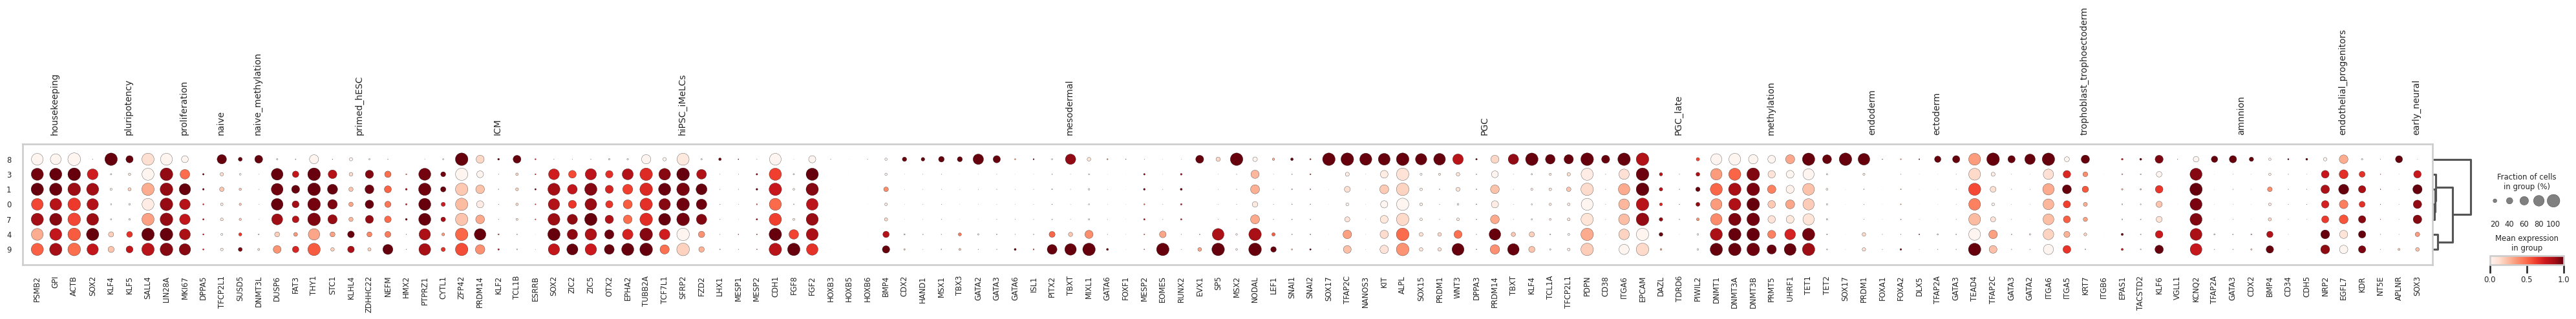

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_CellTypes']`
categories: hEGCLC, hPGCLC, hiPSC, etc.
var_group_labels: housekeeping, pluripotency, proliferation, etc.


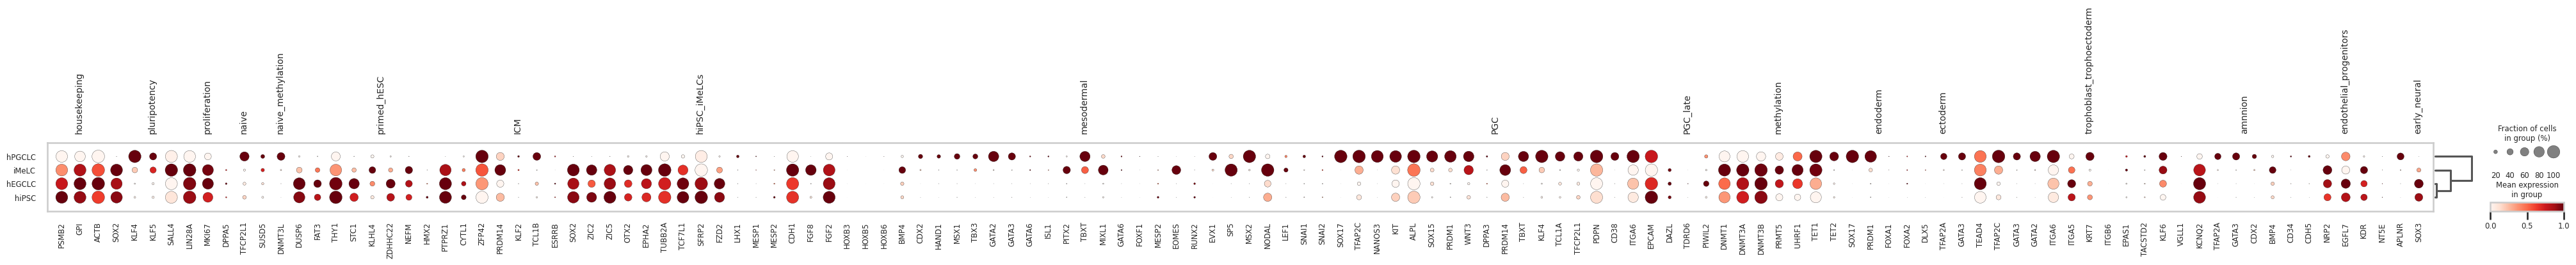

In [10]:
all_dict = {"housekeeping" : ['PSMB2', 'GPI', 'ACTB'],
            "pluripotency" : ["SOX2", "KLF4", "KLF5", "SALL4", "LIN28A"],
            "proliferation" : ["MKI67"],
            "naive" : ["DPPA5", "TFCP2L1", "SUSD5"],
            "naive_methylation" : ["DNMT3L"],
            "primed_hESC" : ["DUSP6","FAT3","THY1","STC1","KLHL4","ZDHHC22","NEFM","HMX2","PTPRZ1","CYTL1"],
            "ICM" : ['ZFP42', 'PRDM14', 'KLF2', 'TCL1B', 'ESRRB'],
            "hiPSC_iMeLCs" : ["SOX2", "ZIC2", "ZIC5", "OTX2", "EPHA2", "TUBB2A", "TCF7L1", "SFRP2", "FZD2", "LHX1", 'MESP1', 'MESP2', 'CDH1', 'FGF8', 'FGF2'],
            "mesodermal" : [ "HOXB3", "HOXB5", "HOXB6", "BMP4", "CDX2", "HAND1", "MSX1", "TBX3", "GATA2", "GATA3", "GATA6", "ISL1", "PITX2", "TBXT", "MIXL1", "GATA6", "FOXF1", "MESP2", "EOMES", "RUNX2", "EVX1", "SP5", "MSX2", "NODAL", 'LEF1', 'SNAI1', 'SNAI2'],
            "PGC" : ["SOX17", "TFAP2C", "NANOS3", "KIT", "ALPL", "SOX15", "PRDM1", "WNT3", "DPPA3", "PRDM14", "TBXT", "KLF4", "TCL1A", "TFCP2L1", "PDPN", "CD38", "ITGA6", "EPCAM"],
            "PGC_late" : ['DAZL',  "TDRD6", "PIWIL2"],
            "methylation" : ['DNMT1', 'DNMT3A', 'DNMT3B', 'PRMT5', 'UHRF1', 'TET1', 'TET2'],
            "endoderm" : ["SOX17", "PRDM1", 'FOXA1', "FOXA2"],
            "ectoderm" : ['DLX5', 'TFAP2A', 'GATA3'],
            "trophoblast_trophoectoderm" : ["TEAD4", "TFAP2C", "GATA3", "GATA2", 'ITGA6', 'ITGA5', "KRT7", "ITGB6", "EPAS1",  "TACSTD2", "KLF6", "VGLL1", 'KCNQ2'],
            "amnnion" : ['TFAP2A', 'GATA3', 'CDX2', "BMP4"],
            "endothelial_progenitors" : ['CD34', "CDH5", "NRP2", "EGFL7", "KDR", "NT5E", "APLNR"],
            "early_neural" : ['SOX3']}

sc.tl.dendrogram(adata,'leiden')
sc.pl.dotplot(adata, all_dict , 'leiden', dendrogram=True,save="2024_05_09_markersDotplot_leiden",use_raw=False,log=True,standard_scale='var')

sc.tl.dendrogram(adata,'CellTypes')
sc.pl.dotplot(adata, all_dict , 'CellTypes', dendrogram=True,save="2024_05_09_markersDotplot_CellTypes",use_raw=False,log=True,standard_scale='var')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 3, etc.
var_group_labels: pluripotency, proliferation, mesodermal, etc.


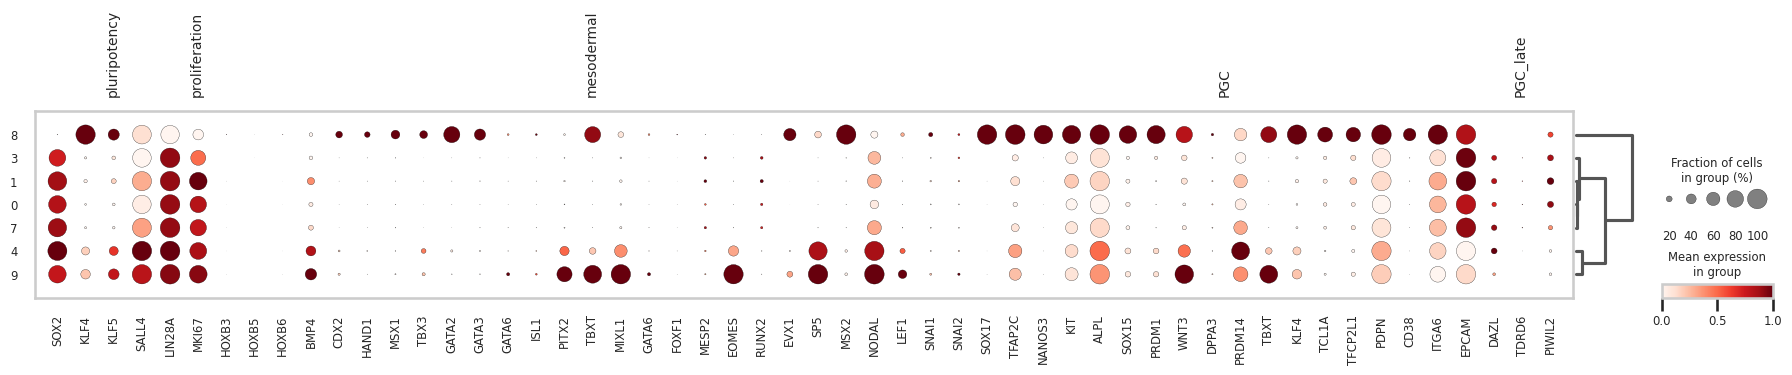

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_CellTypes']`
categories: hEGCLC, hPGCLC, hiPSC, etc.
var_group_labels: pluripotency, proliferation, mesodermal, etc.


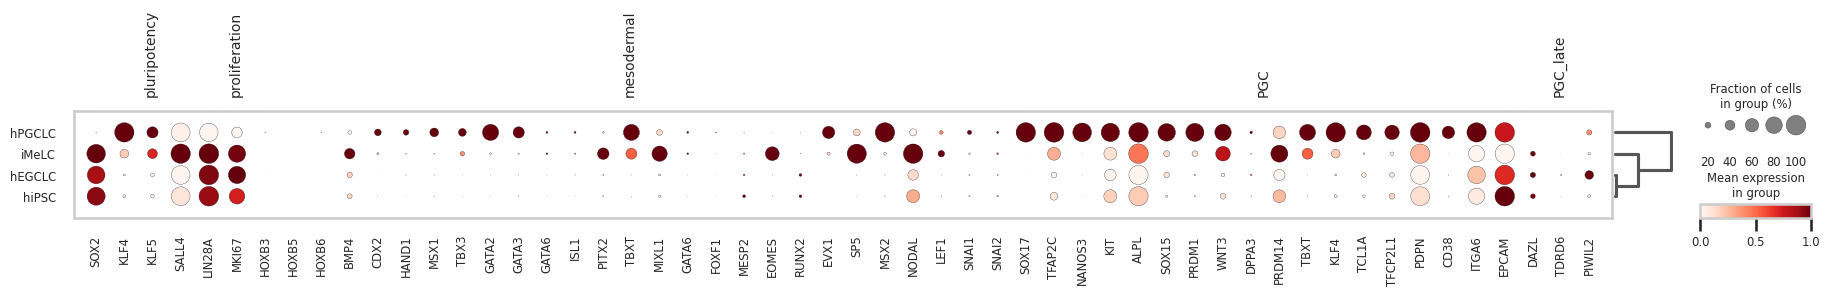

In [11]:
all_dict_1 = {
            "pluripotency" : ["SOX2", "KLF4", "KLF5", "SALL4", "LIN28A"],
            "proliferation" : ["MKI67"],
            "mesodermal" : [ "HOXB3", "HOXB5", "HOXB6", "BMP4", "CDX2", "HAND1", "MSX1", "TBX3", "GATA2", "GATA3", "GATA6", "ISL1", "PITX2", "TBXT", "MIXL1", "GATA6", "FOXF1", "MESP2", "EOMES", "RUNX2", "EVX1", "SP5", "MSX2", "NODAL", 'LEF1', 'SNAI1', 'SNAI2'],
            "PGC" : ["SOX17", "TFAP2C", "NANOS3", "KIT", "ALPL", "SOX15", "PRDM1", "WNT3", "DPPA3", "PRDM14", "TBXT", "KLF4", "TCL1A", "TFCP2L1", "PDPN", "CD38", "ITGA6", "EPCAM"],
            "PGC_late" : ['DAZL',  "TDRD6", "PIWIL2"],
            }

sc.tl.dendrogram(adata,'leiden')
sc.pl.dotplot(adata, all_dict_1 , 'leiden', dendrogram=True,save="2024_05_09_markersDotplot_leiden",use_raw=False,log=True,standard_scale='var')

sc.tl.dendrogram(adata,'CellTypes')
sc.pl.dotplot(adata, all_dict_1 , 'CellTypes', dendrogram=True,save="2024_05_09_markersDotplot_CellTypes",use_raw=False,log=True,standard_scale='var')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_CellTypes']`
categories: hEGCLC, hPGCLC, hiPSC, etc.
var_group_labels: ID, SOX


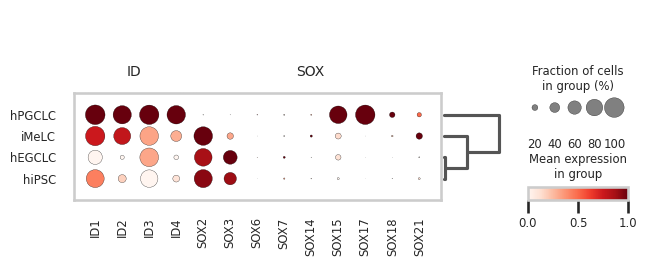

In [12]:
all_dict_2 = {
            "ID" : ["ID1", "ID2", "ID3", "ID4"],
            "SOX" : ["SOX2", "SOX3", "SOX6", "SOX7", "SOX14", "SOX15", "SOX17", "SOX18", "SOX21"]
            }

sc.tl.dendrogram(adata,'CellTypes')
sc.pl.dotplot(adata, all_dict_2 , 'CellTypes', dendrogram=True,use_raw=False,log=True,standard_scale='var')

In [13]:
oracle = co.Oracle()
# In this notebook, we use the unscaled mRNA count for the input of Oracle object.

oracle.import_anndata_as_raw_count(adata=adata_raw,
                                   cluster_column_name='CellTypes',
                                   embedding_name="X_draw_graph_fr")
#oracle.import_anndata_as_normalized_count wants unscaled and uncentered counts

oracle.import_TF_data(TF_info_matrix=base_GRN)

oracle

Oracle object

Meta data
    celloracle version used for instantiation: 0.18.0
    n_cells: 19638
    n_genes: 3280
    cluster_name: CellTypes
    dimensional_reduction_name: X_draw_graph_fr
    n_target_genes_in_TFdict: 21595 genes
    n_regulatory_in_TFdict: 1094 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 255 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 2897 genes
    k_for_knn_imputation: NA
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Not finished
    Knn imputation: Not finished
    GRN calculation for simulation: Not finished

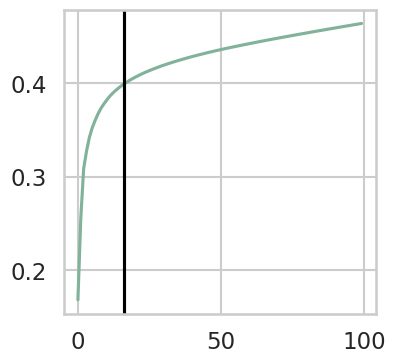

16
cell number is :19638
Auto-selected k is :490


In [14]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100], color = earthy_pal[2])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=8)

In [15]:
oracle.to_hdf5("2024_05_09_PGCLC_CellTypes.celloracle.oracle")

In [16]:
oracle

# Calculate GRN for each cluster.
# This step may take some time.(~30 minutes) white
links = oracle.get_links(cluster_name_for_GRN_unit="CellTypes", alpha=10,
                         verbose_level=10, )


links.links_dict.keys()

Oracle object

Meta data
    celloracle version used for instantiation: 0.18.0
    n_cells: 19638
    n_genes: 3280
    cluster_name: CellTypes
    dimensional_reduction_name: X_draw_graph_fr
    n_target_genes_in_TFdict: 21595 genes
    n_regulatory_in_TFdict: 1094 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 255 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 2897 genes
    k_for_knn_imputation: 490
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
    Knn imputation: Done
    GRN calculation for simulation: Not finished

  0%|          | 0/4 [00:00<?, ?it/s]

Inferring GRN for hEGCLC...


  0%|          | 0/2897 [00:00<?, ?it/s]

Inferring GRN for hPGCLC...


  0%|          | 0/2897 [00:00<?, ?it/s]

Inferring GRN for hiPSC...


  0%|          | 0/2897 [00:00<?, ?it/s]

Inferring GRN for iMeLC...


  0%|          | 0/2897 [00:00<?, ?it/s]

dict_keys(['hEGCLC', 'hPGCLC', 'hiPSC', 'iMeLC'])

In [17]:
links.links_dict.keys()

dict_keys(['hEGCLC', 'hPGCLC', 'hiPSC', 'iMeLC'])

In [18]:
links.to_hdf5(file_path="2024_05_09_PGCLC_CellTypes_1.celloracle.links")

In [19]:
links.links_dict["hEGCLC"]

# Set cluster name
cluster = "hEGCLC"

# Save as csv
links.links_dict[cluster].to_csv("GRN_hEGCLC.csv")

links.links_dict["hPGCLC"]

# Set cluster name
cluster = "hPGCLC"

# Save as csv
links.links_dict[cluster].to_csv("GRN_hPGCLC.csv")

links.links_dict["hiPSC"]

# Set cluster name
cluster = "hiPSC"

# Save as csv
links.links_dict[cluster].to_csv("GRN_hiPSC.csv")

links.links_dict["iMeLC"]

# Set cluster name
cluster = "iMeLC"

# Save as csv
links.links_dict[cluster].to_csv("GRN_iMeLC.csv")

links.links_dict.keys()

links.to_hdf5(file_path="2024_05_09_PGCLC_CellTypes_2.celloracle.links")

,source,target,coef_mean,coef_abs,p,-logp
0,E2F2,A4GALT,-0.000139,0.000139,8.259854e-01,0.083028
1,TFAP2B,A4GALT,0.000000,0.000000,NaN,-0.000000
2,TBX2,A4GALT,0.002105,0.002105,7.263495e-04,3.138854
3,MAF,A4GALT,-0.002493,0.002493,9.886276e-03,2.004967
4,E2F1,A4GALT,0.012186,0.012186,2.743329e-10,9.561722
...,...,...,...,...,...,...
350471,SP3,ZYG11A,-0.004039,0.004039,9.052903e-09,8.043212
350472,BCL3,ZYG11A,0.004329,0.004329,4.223706e-07,6.374306
350473,TP63,ZYG11A,0.000412,0.000412,4.806146e-06,5.318203
350474,ZNF816,ZYG11A,0.000919,0.000919,5.322033e-04,3.273922


,source,target,coef_mean,coef_abs,p,-logp
0,E2F2,A4GALT,-0.001583,0.001583,8.030973e-02,1.095232
1,TFAP2B,A4GALT,-0.004802,0.004802,3.048033e-08,7.515980
2,TBX2,A4GALT,0.000057,0.000057,7.949898e-01,0.099638
3,MAF,A4GALT,-0.003483,0.003483,2.581541e-04,3.588121
4,E2F1,A4GALT,-0.011982,0.011982,1.966049e-09,8.706406
...,...,...,...,...,...,...
350471,SP3,ZYG11A,0.008460,0.008460,9.469434e-16,15.023676
350472,BCL3,ZYG11A,0.004711,0.004711,9.831462e-06,5.007382
350473,TP63,ZYG11A,0.000055,0.000055,7.759801e-01,0.110149
350474,ZNF816,ZYG11A,0.010861,0.010861,1.269887e-14,13.896235


,source,target,coef_mean,coef_abs,p,-logp
0,E2F2,A4GALT,0.001962,0.001962,7.726034e-03,2.112043
1,TFAP2B,A4GALT,0.000000,0.000000,NaN,-0.000000
2,TBX2,A4GALT,0.000143,0.000143,6.566184e-01,0.182687
3,MAF,A4GALT,-0.006736,0.006736,1.348427e-10,9.870173
4,E2F1,A4GALT,0.006165,0.006165,1.770085e-10,9.752006
...,...,...,...,...,...,...
350471,SP3,ZYG11A,-0.007594,0.007594,3.454300e-09,8.461640
350472,BCL3,ZYG11A,0.016571,0.016571,5.683222e-15,14.245405
350473,TP63,ZYG11A,-0.000181,0.000181,4.617308e-01,0.335611
350474,ZNF816,ZYG11A,-0.003701,0.003701,3.364209e-07,6.473117


,source,target,coef_mean,coef_abs,p,-logp
0,E2F2,A4GALT,0.005337,0.005337,6.968550e-08,7.156858
1,TFAP2B,A4GALT,0.000581,0.000581,7.770968e-02,1.109525
2,TBX2,A4GALT,0.001598,0.001598,5.916519e-05,4.227934
3,MAF,A4GALT,0.010437,0.010437,9.697370e-13,12.013346
4,E2F1,A4GALT,0.009388,0.009388,4.290203e-08,7.367522
...,...,...,...,...,...,...
350471,SP3,ZYG11A,0.004214,0.004214,1.057876e-04,3.975565
350472,BCL3,ZYG11A,0.003921,0.003921,8.687331e-04,3.061114
350473,TP63,ZYG11A,0.004672,0.004672,6.817922e-13,12.166348
350474,ZNF816,ZYG11A,-0.003302,0.003302,7.424926e-08,7.129308


dict_keys(['hEGCLC', 'hPGCLC', 'hiPSC', 'iMeLC'])

In [20]:
links = co.load_hdf5(file_path="2024_05_09_PGCLC_CellTypes_2.celloracle.links")

hEGCLC


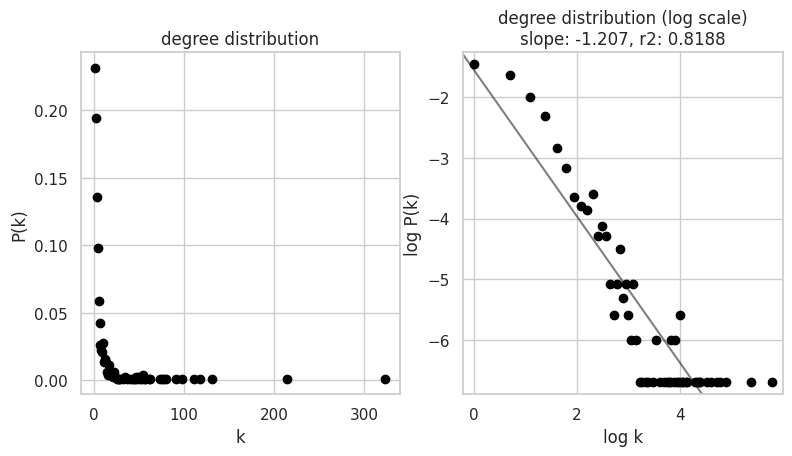

hPGCLC


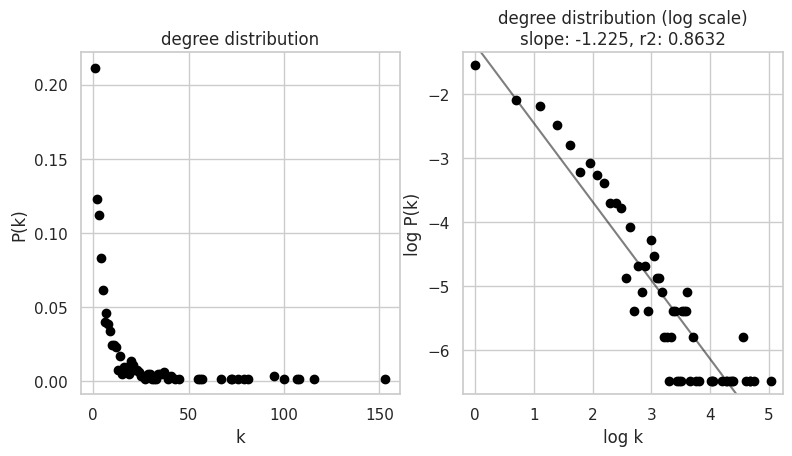

hiPSC


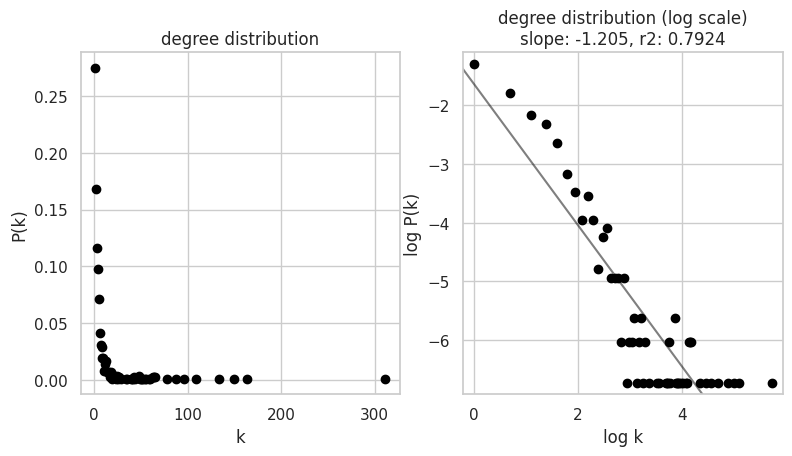

iMeLC


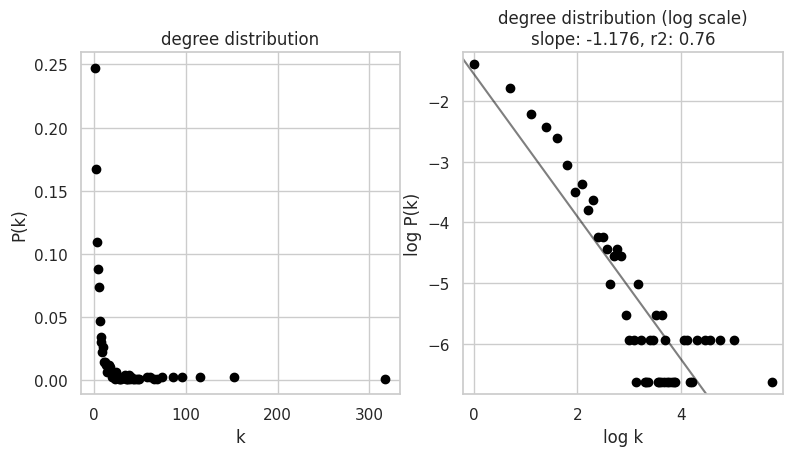

In [21]:
# filter by pvalue
# filter the top 3000 edges by strength
links.filter_links(p=0.001, weight="coef_abs", threshold_number=3000)

sns.set_context("notebook")
plt.rcParams["figure.figsize"] = [9, 4.5]

links.plot_degree_distributions(plot_model=True,
                                save=f"{save_folder}/degree_distribution/",
                               )

# Calculate network scores.

In [22]:
links.get_network_score()

In [23]:
links.merged_score.head()

# Save Links object.

links.to_hdf5(file_path="2024_05_09_PGCLC_CellTypes_merged.celloracle.links")

,degree_all,degree_centrality_all,degree_in,degree_centrality_in,degree_out,degree_centrality_out,betweenness_centrality,eigenvector_centrality,cluster
ZNF165,54,0.067248,1,0.001245,53,0.066002,40.0,0.208954,hEGCLC
HIST1H1C,51,0.063512,51,0.063512,0,0.000000,0.0,0.401413,hEGCLC
SOX3,29,0.036115,0,0.000000,29,0.036115,0.0,0.231489,hEGCLC
HIST1H2BH,49,0.061021,49,0.061021,0,0.000000,0.0,0.351283,hEGCLC
HDAC2,325,0.404732,3,0.003736,322,0.400996,4972.0,1.000000,hEGCLC


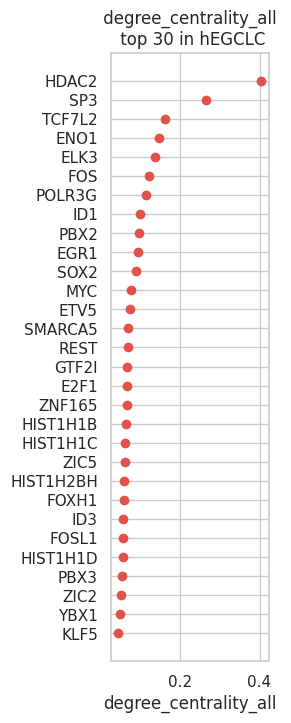

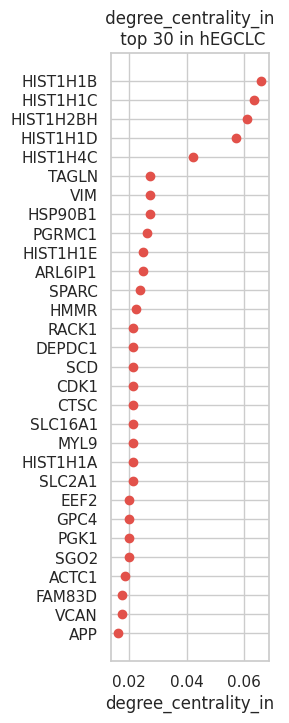

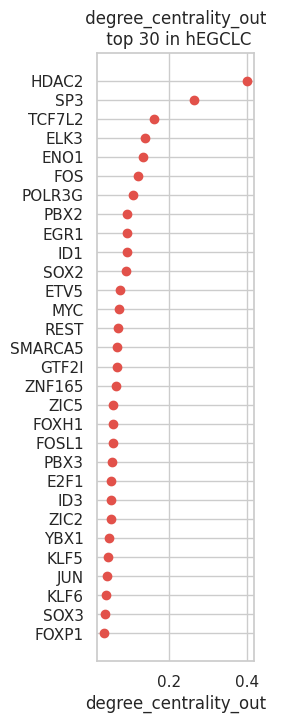

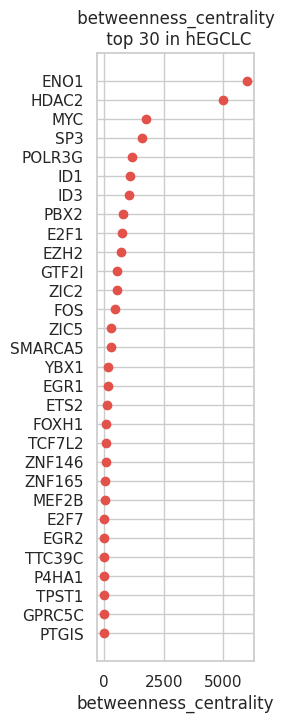

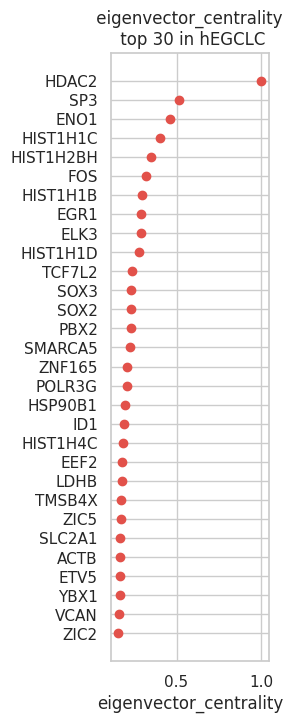

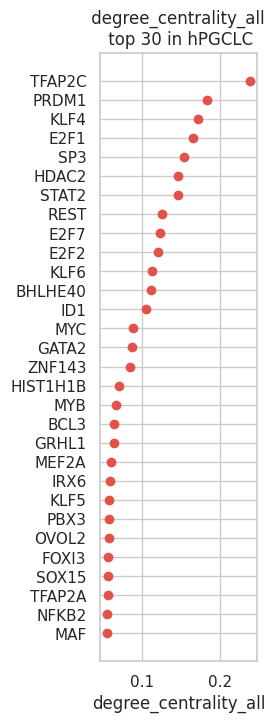

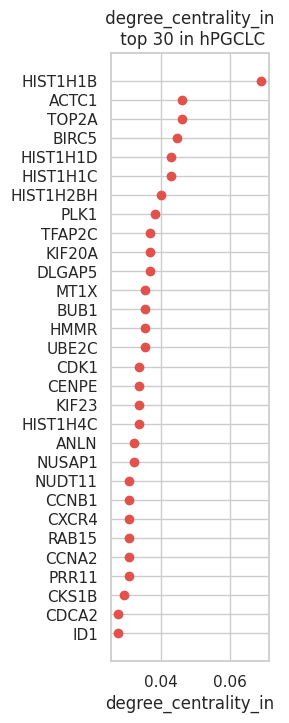

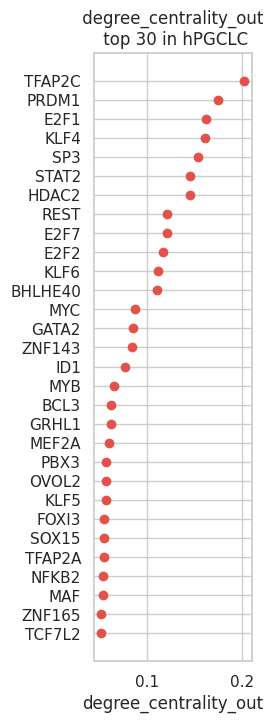

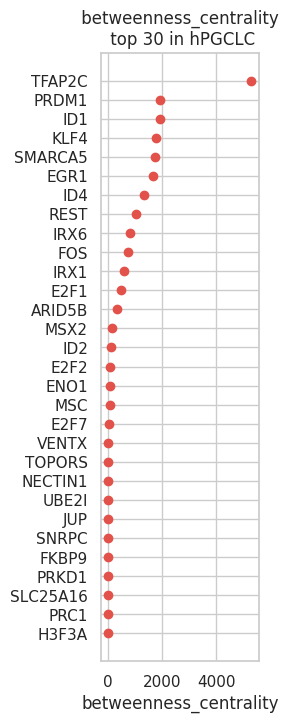

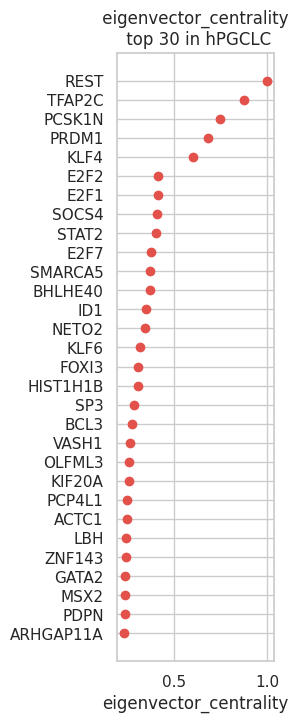

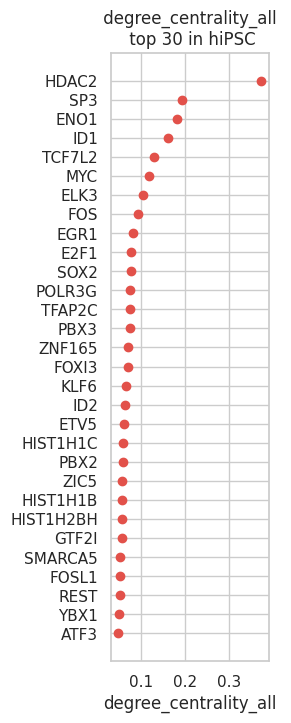

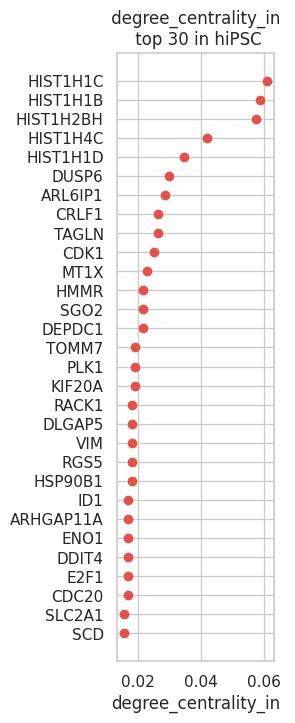

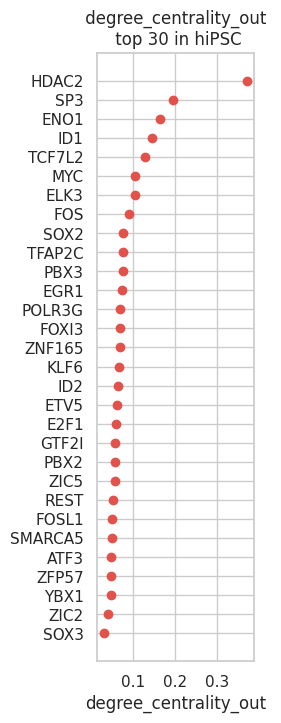

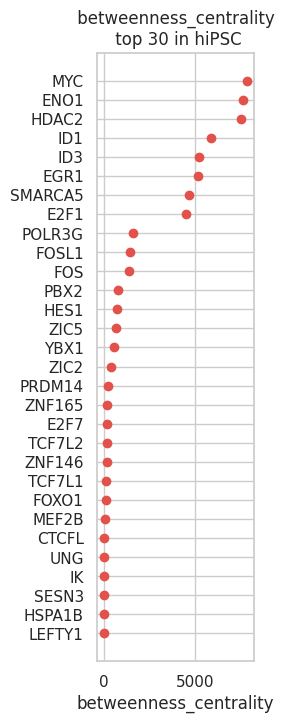

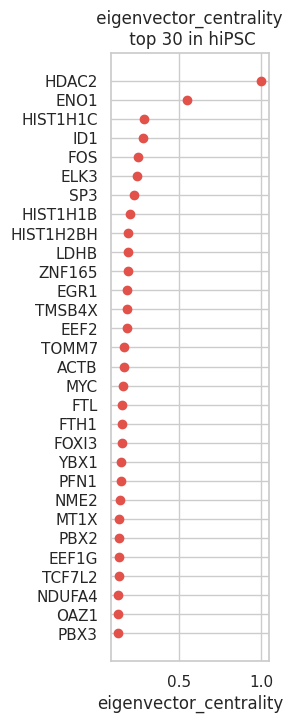

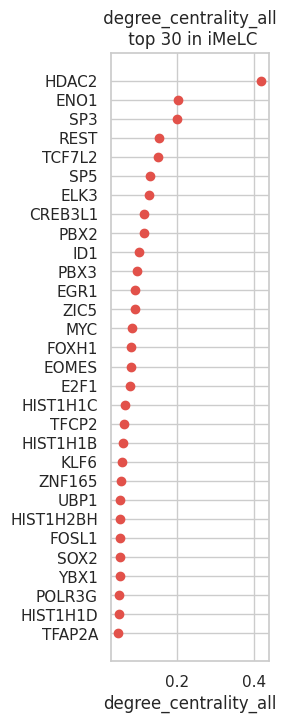

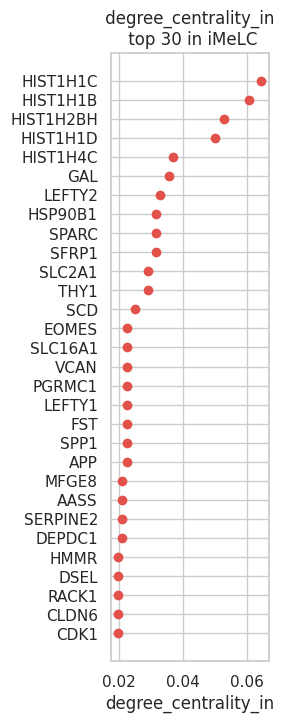

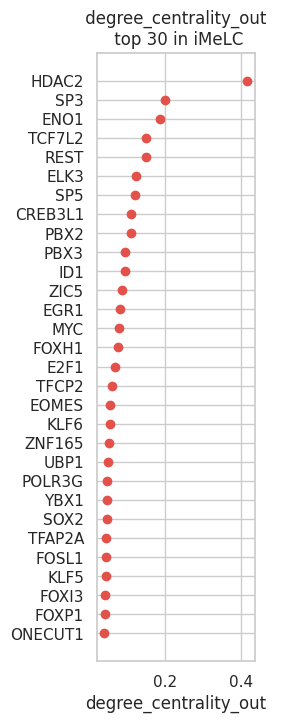

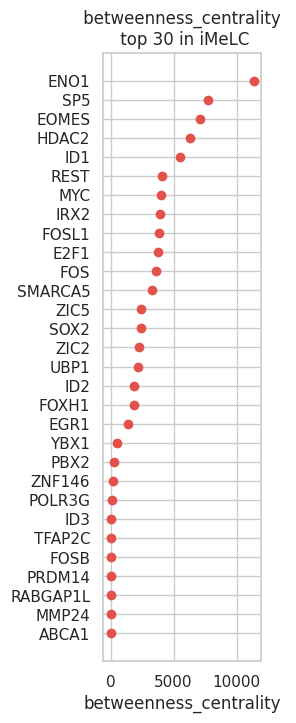

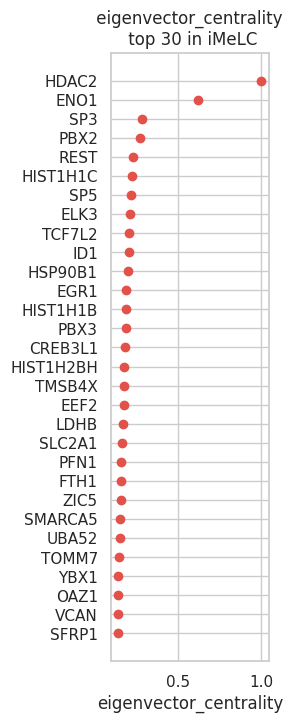

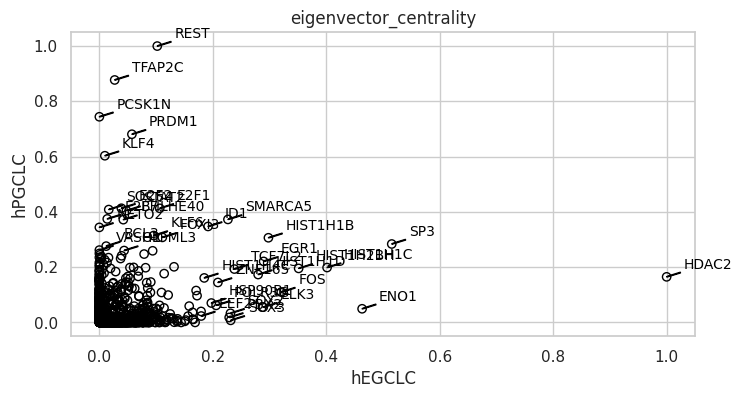

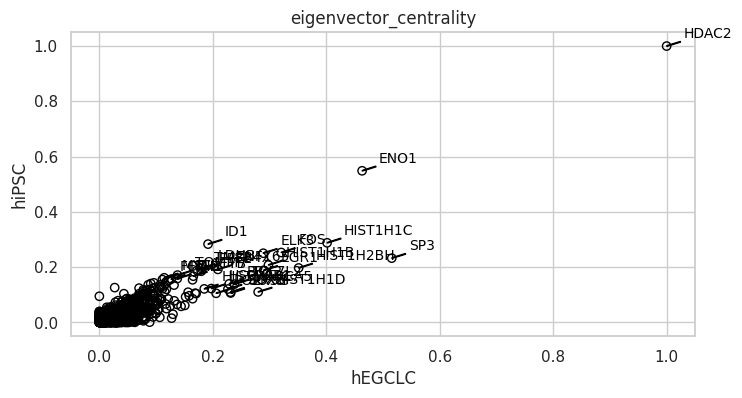

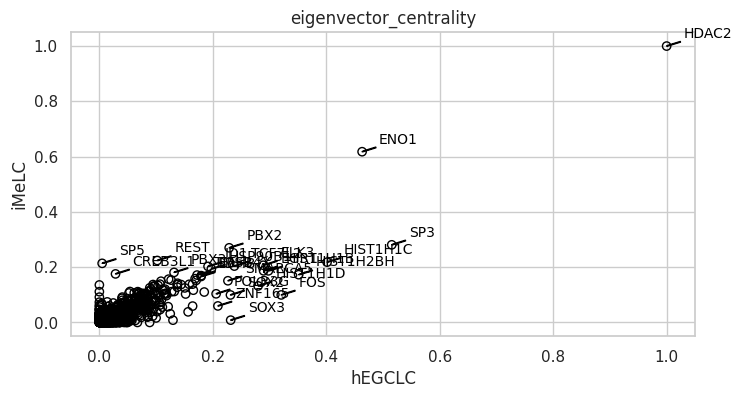

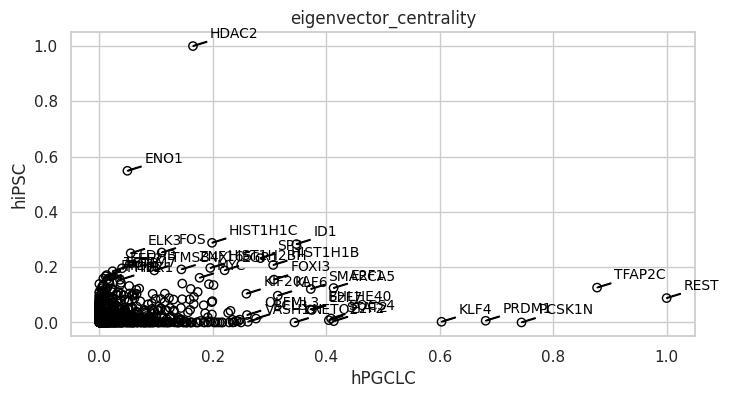

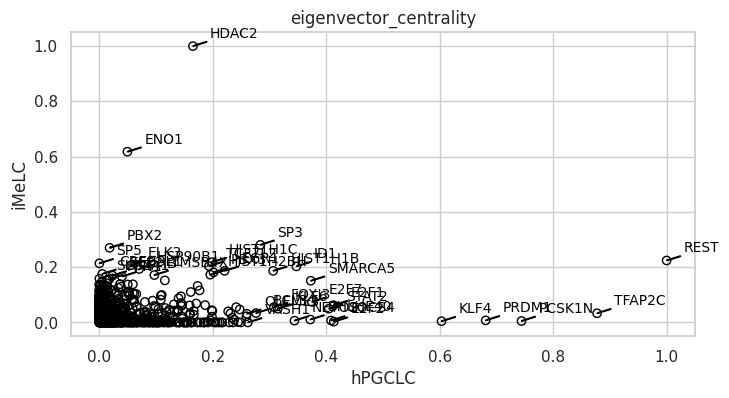

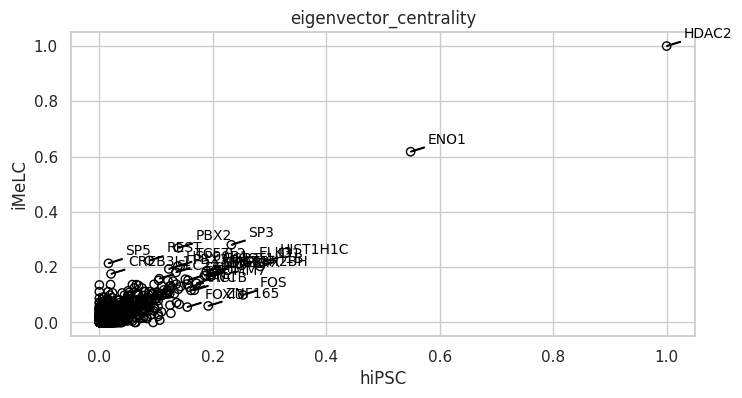

SOX2


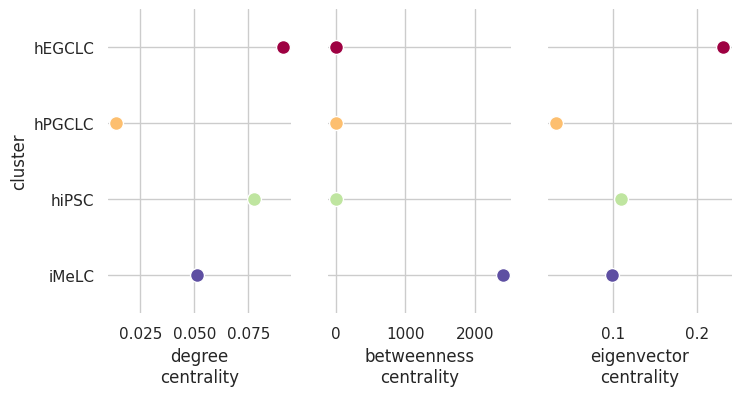

NANOG


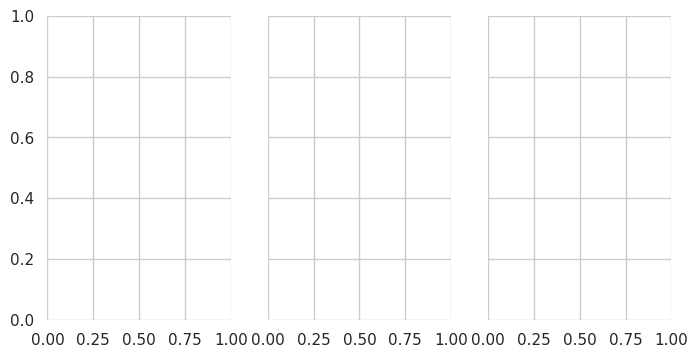

POU5F1


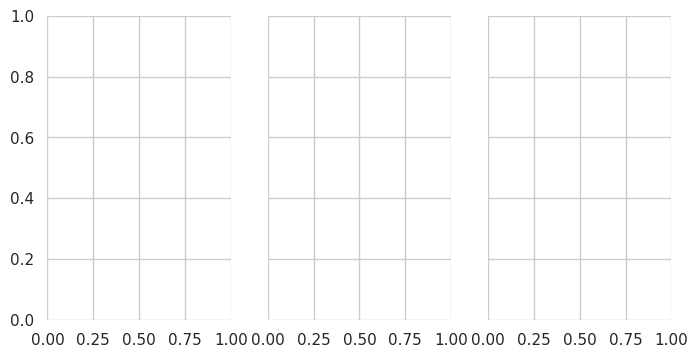

EOMES


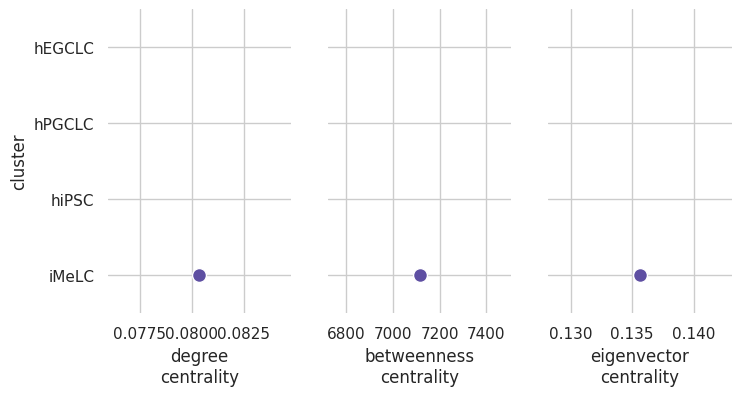

SP5


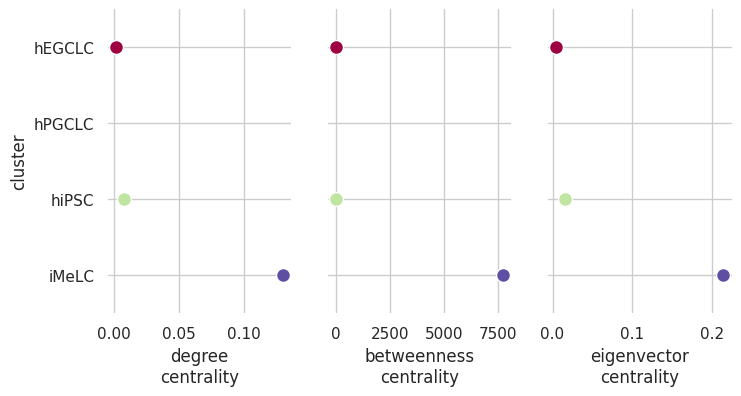

TFAP2C


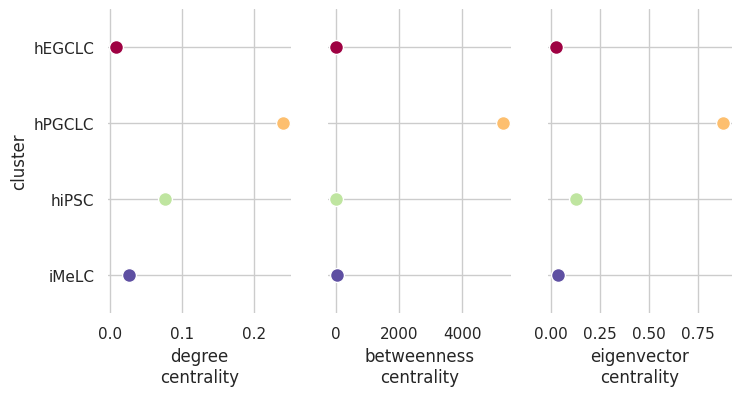

SOX17


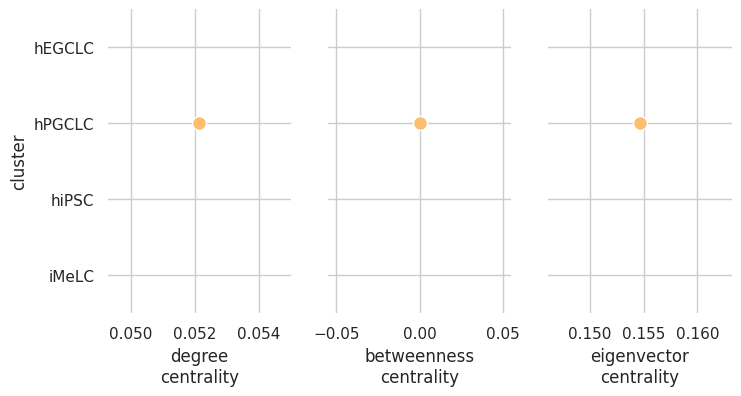

NANOS3


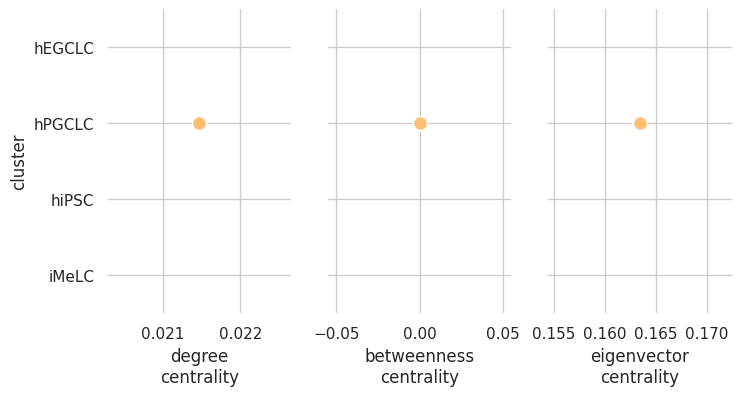

BLIMP1


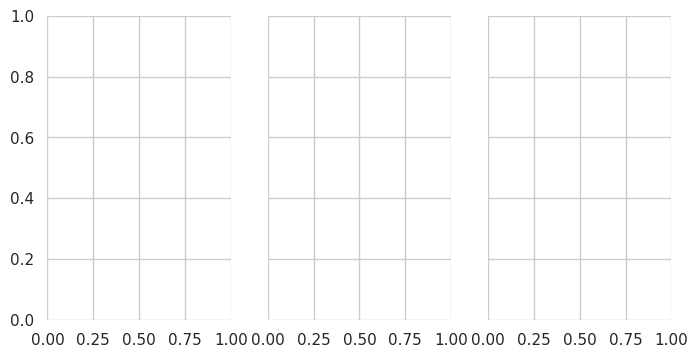

PIWIL2


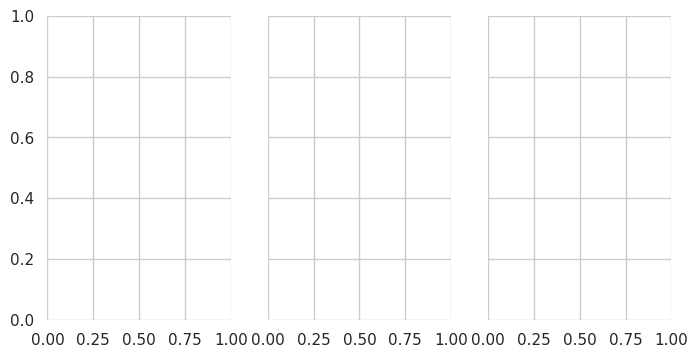

(0.0, 0.03)

degree_centrality_all


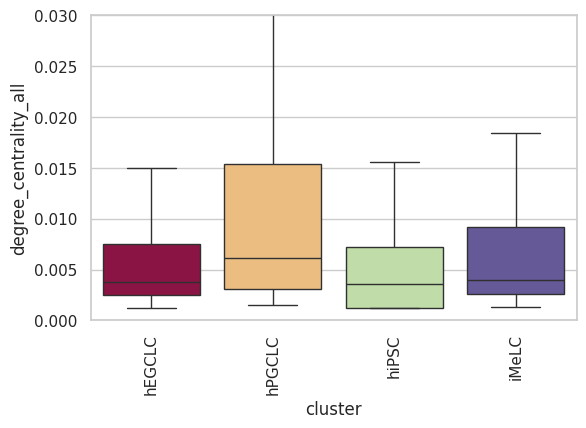

(0.0, 0.25)

eigenvector_centrality


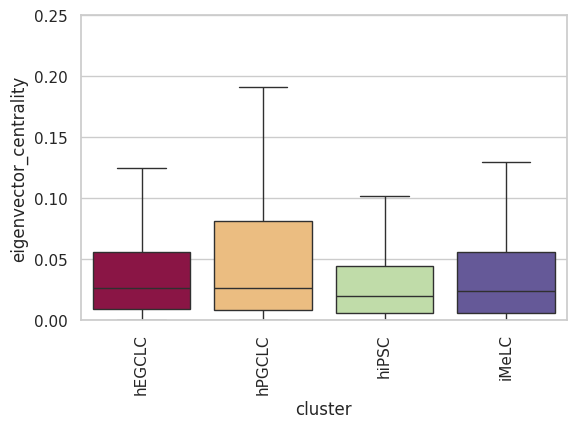

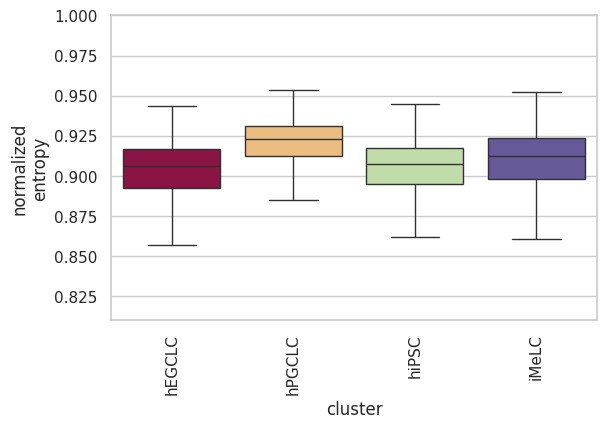

In [24]:
plt.rcParams["figure.figsize"] = [4.5, 8]

sns.set_context("notebook")
# Visualize top n-th genes with high scores.
links.plot_scores_as_rank(cluster="hEGCLC", n_gene=30, save=f"{save_folder}/ranked_score_hEGCLC")

sns.set_context("notebook")
# Visualize top n-th genes with high scores.
links.plot_scores_as_rank(cluster="hPGCLC", n_gene=30, save=f"{save_folder}/ranked_score_hPGCLC")

sns.set_context("notebook")
# Visualize top n-th genes with high scores.
links.plot_scores_as_rank(cluster="hiPSC", n_gene=30, save=f"{save_folder}/ranked_score_hiPSC")

sns.set_context("notebook")
# Visualize top n-th genes with high scores.
links.plot_scores_as_rank(cluster="iMeLC", n_gene=30, save=f"{save_folder}/ranked_score_iMeLC")

plt.rcParams["figure.figsize"] = [8, 4]
# Compare GRN score between two clusters
links.plot_score_comparison_2D(value="eigenvector_centrality",
                               cluster1="hEGCLC", cluster2="hPGCLC",
                               percentile=98,
                               save=f"{save_folder}/score_comparison_hEGCLC_hPGCLC")

plt.rcParams["figure.figsize"] = [8, 4]
# Compare GRN score between two clusters
links.plot_score_comparison_2D(value="eigenvector_centrality",
                               cluster1="hEGCLC", cluster2="hiPSC",
                               percentile=98,
                               save=f"{save_folder}/score_comparison_hEGCLC_hiPSC")

plt.rcParams["figure.figsize"] = [8, 4]
# Compare GRN score between two clusters
links.plot_score_comparison_2D(value="eigenvector_centrality",
                               cluster1="hEGCLC", cluster2="iMeLC",
                               percentile=98,
                               save=f"{save_folder}/score_comparison_hEGCLC_iMeLC")

plt.rcParams["figure.figsize"] = [8, 4]
# Compare GRN score between two clusters
links.plot_score_comparison_2D(value="eigenvector_centrality",
                               cluster1="hPGCLC", cluster2="hiPSC",
                               percentile=98,
                               save=f"{save_folder}/score_comparison_hPGCLC_hiPSC")

plt.rcParams["figure.figsize"] = [8, 4]
# Compare GRN score between two clusters
links.plot_score_comparison_2D(value="eigenvector_centrality",
                               cluster1="hPGCLC", cluster2="iMeLC",
                               percentile=98,
                               save=f"{save_folder}/score_comparison_hPGCLC_iMeLC")

plt.rcParams["figure.figsize"] = [8, 4]
# Compare GRN score between two clusters
links.plot_score_comparison_2D(value="eigenvector_centrality",
                               cluster1="hiPSC", cluster2="iMeLC",
                               percentile=98,
                               save=f"{save_folder}/score_comparison_hiPSC_iMeLC")

links.plot_score_per_cluster(goi="SOX2", save=f"{save_folder}/network_score_per_SOX2/")
links.plot_score_per_cluster(goi="NANOG", save=f"{save_folder}/network_score_per_NANOG/")
links.plot_score_per_cluster(goi="POU5F1", save=f"{save_folder}/network_score_per_POU5F1/")
links.plot_score_per_cluster(goi="EOMES", save=f"{save_folder}/network_score_per_EOMES/")
links.plot_score_per_cluster(goi="SP5", save=f"{save_folder}/network_score_per_SP5/")
links.plot_score_per_cluster(goi="TFAP2C", save=f"{save_folder}/network_score_per_TFAP2C/")
links.plot_score_per_cluster(goi="SOX17", save=f"{save_folder}/network_score_per_SOX17/")
links.plot_score_per_cluster(goi="NANOS3", save=f"{save_folder}/network_score_per_NANOS3/")
links.plot_score_per_cluster(goi="BLIMP1", save=f"{save_folder}/network_score_per_BLIMP1/")
links.plot_score_per_cluster(goi="PIWIL2", save=f"{save_folder}/network_score_per_PIWIL2/")


plt.rcParams["figure.figsize"] = [6, 5]

# Plot degree_centrality
plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([0,0.030])
links.plot_score_discributions(values=["degree_centrality_all"],
                               method="boxplot",
                               save=f"{save_folder}",
                              )

# Plot eigenvector_centrality
plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([0, 0.25])
links.plot_score_discributions(values=["eigenvector_centrality"],
                               method="boxplot",
                               save=f"{save_folder}")

plt.subplots_adjust(left=0.15, bottom=0.3)
links.plot_network_entropy_distributions(save=f"{save_folder}")

In [25]:
adata.var_names

Index(['SAMD11', 'NOC2L', 'KLHL17', 'PLEKHN1', 'HES4', 'ISG15', 'AGRN',
       'C1orf159', 'TTLL10', 'TNFRSF18',
       ...
       'MT-ND2', 'MT-CO2', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4',
       'MT-ND5', 'MT-ND6', 'MT-CYB'],
      dtype='object', length=14582)

In [26]:
adata.shape

(19638, 14582)

WNT7A


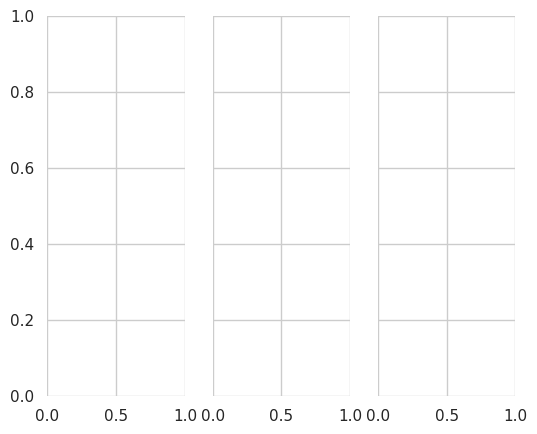

MSX1


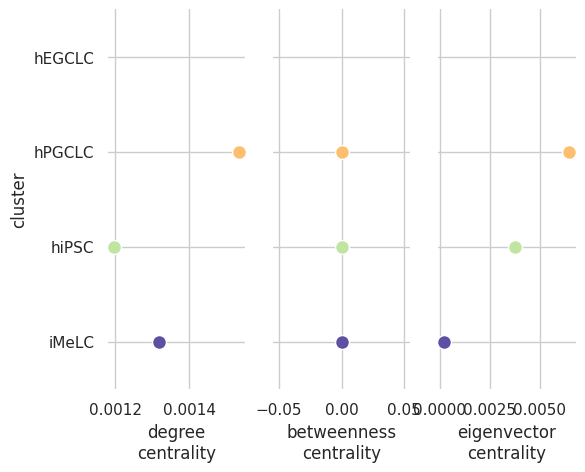

MSX2


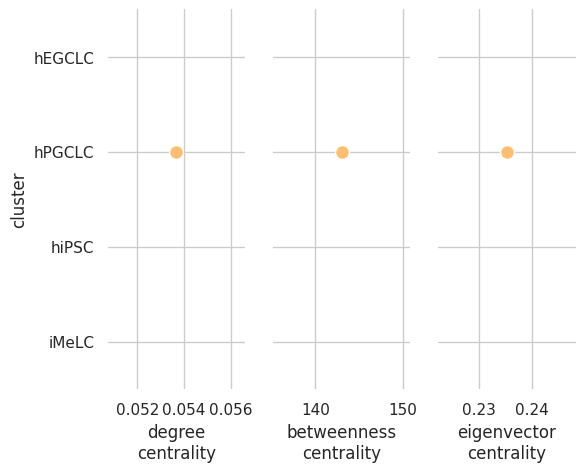

DNMT3L


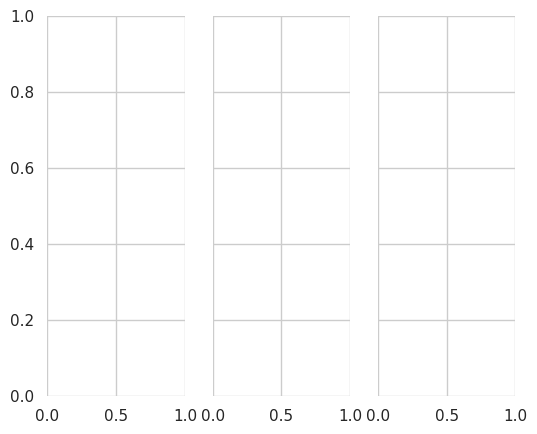

GATA3


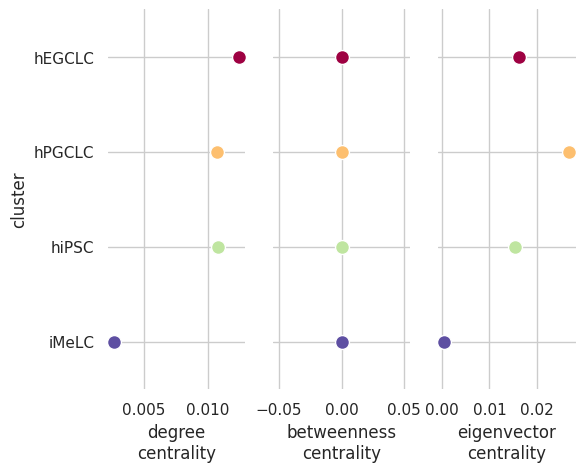

GATA2


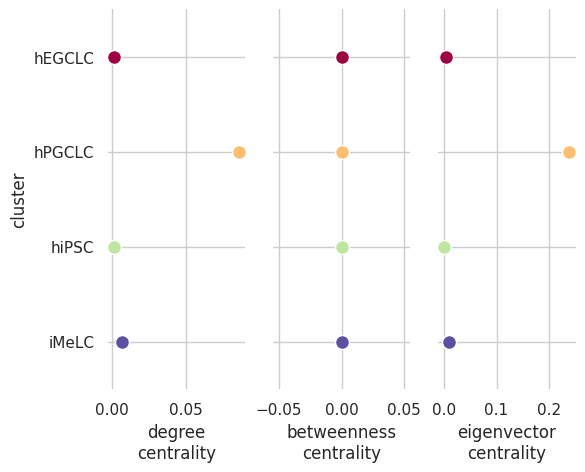

In [27]:
links.plot_score_per_cluster(goi="WNT7A", save=f"{save_folder}/network_score_per_WNT7A/")
links.plot_score_per_cluster(goi="MSX1", save=f"{save_folder}/network_score_per_MSX1/")
links.plot_score_per_cluster(goi="MSX2", save=f"{save_folder}/network_score_per_MSX2/")
links.plot_score_per_cluster(goi="DNMT3L", save=f"{save_folder}/network_score_per_DNMT3L/")
links.plot_score_per_cluster(goi="GATA3", save=f"{save_folder}/network_score_per_GATA3/")
links.plot_score_per_cluster(goi="GATA2", save=f"{save_folder}/network_score_per_GATA2/")


PRDM1


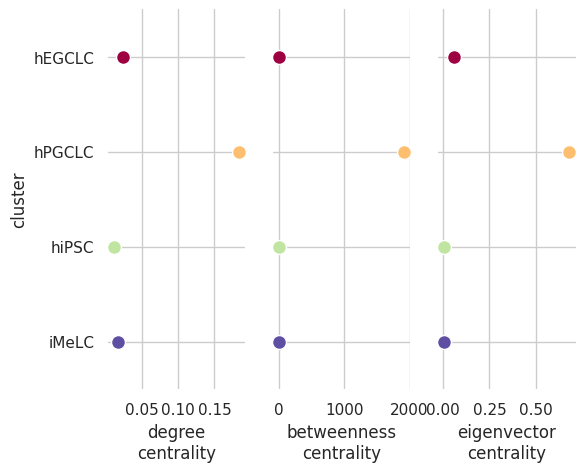

LSD1


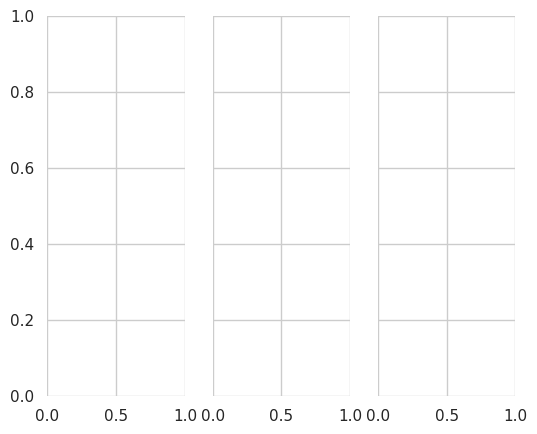

GTF2I


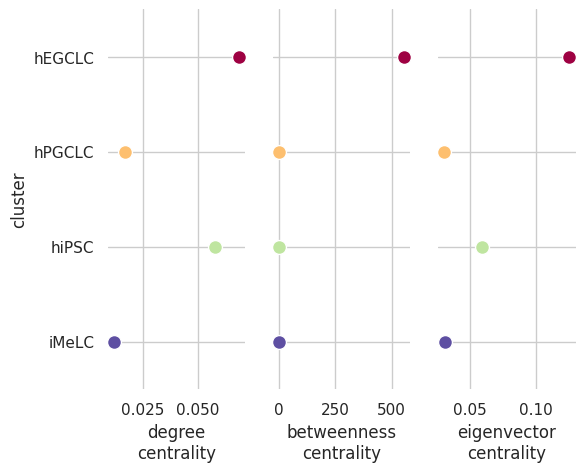

ADNP


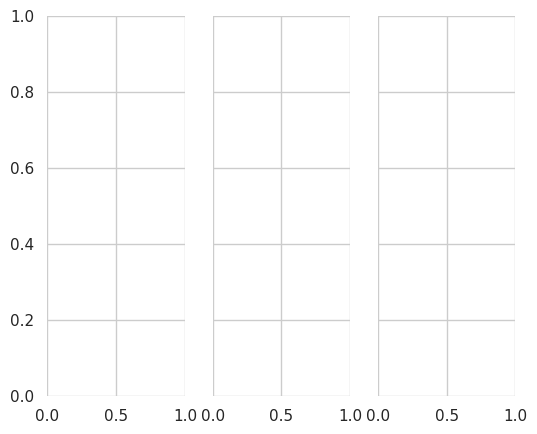

In [29]:
links.plot_score_per_cluster(goi="PRDM1", save=f"{save_folder}/network_score_per_PRDM1/")
links.plot_score_per_cluster(goi="LSD1", save=f"{save_folder}/network_score_per_LSD1/")
links.plot_score_per_cluster(goi="GTF2I", save=f"{save_folder}/network_score_per_GTF2I/")
links.plot_score_per_cluster(goi="ADNP", save=f"{save_folder}/network_score_per_ADNP/")